In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import sys
sys.path.insert(1, "../data")

In [2]:
data = scipy.io.loadmat("../data/sampleEEGdata.mat")

chanlocs = [data["EEG"]['chanlocs'][0][0][0][i][0] for i in range(64)]
srate = int(data["EEG"]["srate"])
dataE = data["EEG"][0][0][15]
timeEEG = data["EEG"][0][0][14]

baselineWindow = [[-500,-200],[-100,0],[0,300],[-800,0]]
baseidx = [[int(np.argmin(abs(timeEEG-baselineWindow[i][0]))),int(np.argmin(abs(timeEEG-baselineWindow[i][1])))] for i in range(len(baselineWindow))]

numFrex = 40
minFrex = 2
maxFrex = 30

frex = np.linspace(minFrex, maxFrex, numFrex)

channel2use = "O1"
chanidx = chanlocs.index(channel2use)

range_cycles = [4,10]

s = np.logspace(np.log10(range_cycles[0]), np.log10(range_cycles[-1]), numFrex) / (2*np.pi*frex)
wavtime = np.arange(-2, 2, 1/srate)
half_wave = int((len(wavtime)-1)/2)

nWave = len(wavtime)
nData = dataE.shape[1] * dataE.shape[2]
nConv = nWave + nData - 1

dataX = scipy.fft.fft(np.reshape(dataE[chanidx,:,:],(1,nData), order="F"), nConv)

tf = np.zeros((len(baseidx), len(frex), dataE.shape[1]))

for fi in range(numFrex):
 
    wavelet = np.exp(2*1j*np.pi*frex[fi]*wavtime) * np.exp(-wavtime**2 / (2*s[fi]**2))
    waveletX = scipy.fft.fft(wavelet, nConv)
 
    waveletX = waveletX / np.max(waveletX)
 
    as_ = scipy.fft.ifft(waveletX * dataX, nConv)
    as_ = as_[0,half_wave:-half_wave-1]
    as_ = np.reshape(as_, (dataE.shape[1],dataE.shape[2]), order="F")
    tf[3,fi,:] = np.mean(abs(as_)**2, 1)
 

for basei in range(tf.shape[0]):
    activity = np.squeeze(tf[3,:,:])
    baseline = np.mean(tf[3,:, baseidx[basei][0]:baseidx[basei][1]], axis=1)
    baseline = baseline[:, np.newaxis]
    
    tf[basei,:,:] = 10*np.log10(activity/baseline)

C:\Users\kerem\AppData\Local\Temp\ipykernel_14932\1968061367.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  srate = int(data["EEG"]["srate"])


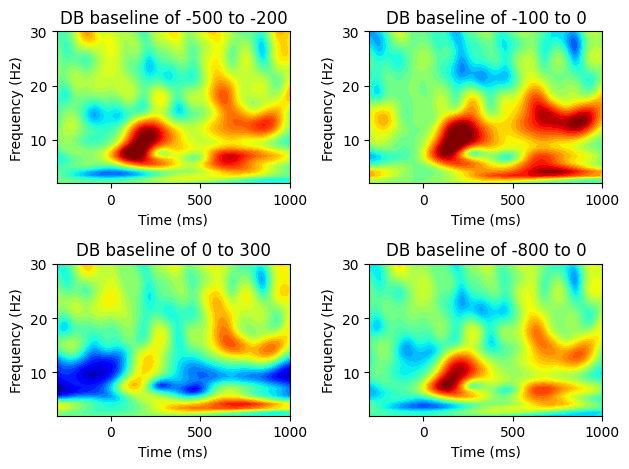

In [3]:
for basei in range(len(baselineWindow)):
    plt.subplot(2, 2, basei+1)
    plt.contourf(np.squeeze(timeEEG), frex, np.squeeze(tf[basei,:,:]), 40, vmin=-3, vmax=3, cmap="jet")
    plt.xlim([-300,1000])
    plt.title(f"DB baseline of {baselineWindow[basei][0]} to {baselineWindow[basei][1]}")
    plt.xlabel("Time (ms)")
    plt.ylabel("Frequency (Hz)")

plt.tight_layout()
